In [11]:
import requests
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import time
import datetime
from datetime import datetime, date
from datetime import timedelta
import talib
import pickle
from scipy import stats
from datetime import datetime as dt
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import Imputer, RobustScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score,log_loss
from sklearn.model_selection import GridSearchCV


In [2]:
def hourly_price_historical(symbol, comparison_symbol, limit, aggregate, exchange=''):
    url = 'https://min-api.cryptocompare.com/data/histohour?fsym={}&tsym={}&limit={}&aggregate={}'\
            .format(symbol.upper(), comparison_symbol.upper(), limit, aggregate)
    if exchange:
        url += '&e={}'.format(exchange)
    page = requests.get(url)
    data = page.json()['Data']
    df = pd.DataFrame(data)
    df['timestamp'] = [datetime.fromtimestamp(d) for d in df.time]
    return df

cb=hourly_price_historical('BTC','USD',999,1, exchange='Coinbase')

In [145]:
tickers = ['USDT_BTC','USDT_ETC','USDT_EOS','USDT_XMR','USDT_ETH','USDT_DASH','USDT_BAT','USDT_GNT',
 'USDT_XRP','USDT_LTC','USDT_XLM','USDT_REP','USDT_ZEC','USDT_IOT','USDT_NEO','USDT_BCH','USDT_TRX','USDT_OMG','USDT_XVG']#bitfinex

def get_data(date,coin):
    """ Query the API for 2000 days historical price data starting from "date". """
    url = "https://min-api.cryptocompare.com/data/histohour?fsym="+coin+"&tsym=USD&limit=1000&toTs={}".format(date)
    r = requests.get(url)
    ipdata = r.json()
    return ipdata

def get_hourly(date,coin, exchange=''):
    url = 'https://min-api.cryptocompare.com/data/histohour?fsym='+coin+'&tsym=USD&limit=999&toTs={}'\
            .format(date)
    if exchange:
        url += '&e={}'.format(exchange)
    page = requests.get(url)
    data = page.json()#['Data']
    #df = pd.DataFrame(data)
    #df['timestamp'] = [datetime.fromtimestamp(d) for d in df.time]
    return data


def get_df(from_date, to_date,coin):
    """ Get historical price data between two dates. """
    date = to_date
    holder = []
    # While the earliest date returned is later than the earliest date requested, keep on querying the API
    while date > from_date:
        data = get_hourly(date,coin,exchange='Bitfinex')
        holder.append(pd.DataFrame(data['Data']))
        date = data['TimeFrom']
    # Join together all of the API queries in the list.    
    df = pd.concat(holder, axis = 0)                    
    # Remove data points from before from_date
    df = df[df['time']>from_date]                       
    # Convert to timestamp to readable date format
    df['time'] = pd.to_datetime(df['time'], unit='s')   
    # Make the DataFrame index the time
    df.set_index('time', inplace=True)                  
    # And sort it so its in time order 
    df.sort_index(ascending=True, inplace=True) 
    df.to_csv("1h_"+coin + '.csv')
    print('Processed: ' + coin)
    return df

from_date = date(2013,1,1)
to_date=datetime.now()

start= time.mktime(from_date.timetuple())
end = time.mktime(to_date.timetuple())


for x in tickers:#query all coins
    get_df(start,end,x[5:])
    

In [147]:
df=get_df(start,end,"BTC")
df.tail()

Processed: BTC


,close,high,low,open,volumefrom,volumeto
time,,,,,,
2019-04-05 03:00:00,4940.34,4965.0,4932.70,4965.00,64.21,317839.87
2019-04-05 04:00:00,4990.95,5014.0,4940.10,4940.34,450.98,2247931.29
2019-04-05 05:00:00,5027.85,5068.8,4990.90,4990.95,990.71,4987319.74
2019-04-05 06:00:00,4985.93,5027.9,4984.10,5027.85,216.35,1083357.39
2019-04-05 07:00:00,4996.40,5005.2,4985.19,4985.93,165.97,828726.51


In [63]:
#create the features for each coin
def retrieve_symbol_name(coin,window):
    col=['date','close']
    ndf=pd.read_csv("1h_"+coin+'.csv',index_col='time')
    ndf=ndf.drop(["volumefrom"],axis=1)
    ndf.index=pd.to_datetime(ndf.index)
    df=pd.DataFrame()
    unique_dates=ndf.index.drop_duplicates(keep='first')
    for i in unique_dates:
        if len(ndf.loc[i])>2:
            df=df.append(ndf.loc[i])
        else:
            df=df.append(ndf.loc[i].iloc[1,:])
    df['%_change']=df['close'].pct_change()
    df['coin']=coin
    df['RSI']=talib.RSI(df['close'], timeperiod=window)
    df['RSI_10']=df['RSI'].rolling(10).mean()
    df['RSI_50']=df['RSI'].rolling(50).mean()
    df['RSI_up']= (df['RSI_10']> df['RSI_50']).astype(float)
    df['10_MA']=df['close'].rolling(10).mean()
    df['50_MA']=df['close'].rolling(50).mean()
    df['MA_up']= (df['10_MA']> df['50_MA']).astype(float)
    df['volume_10']=df['volumeto'].rolling(10).mean()
    df['volume_50']=df['volumeto'].rolling(50).mean()
    df['vol_up']= (df['volume_10']> df['volume_50']).astype(float)
    df['vol']=df['%_change'].rolling(30).var()
    df['50_vol']=df['vol'].rolling(50).mean()
    df['200_vol']=df['vol'].rolling(200).mean()
    close = df['close']
    high = df['high']
    low = df['low']
    df['ATR'] = talib.ATR(high, low, close, window)
    df['50_Std']=df['%_change'].rolling(50*6).std()
    df['rise']=(df['%_change']>2*df['50_Std']).astype(float)
    df['fall']=(df['%_change']<-2*df['50_Std']).astype(float)
    df['ADX'] = talib.ADX(high, low, close, window)
    macd, macdsignal, macdhist = talib.MACD(df['close'], fastperiod=12, slowperiod=26, signalperiod=9)
    df['MACD']=macd
    df['MACD_Hist']=macdhist
    df['MACD_Signal']=macdsignal
    df['MACD_Hist_change']= df['MACD_Hist'].pct_change()
    df['Hist_std']=df['MACD_Hist_change'].rolling(50*6).std()
    df['MACD_signal']=(df['MACD_Hist_change']>df['Hist_std']).astype(float)
    df.index=pd.to_datetime(df.index)
    df=df.dropna()
    hour=[]
    for i in df.index:
        hour.append(int(str(i)[11:13]))
    df['hour']=hour
    df['1_day_high']=df['high'].rolling(24).max()
    df['1_day_low']=df['low'].rolling(24).min()
    low=[]
    maxx=[]
    date=[]
    exit=[]
    for i in df.index:
        if i+timedelta(hours=24) < df.index[-1]:
            low.append(df['1_day_low'].loc[i+timedelta(hours=24)])
            maxx.append(df['1_day_high'].loc[i+timedelta(hours=24)])
            date.append(i)
            exit.append(df['close'].loc[i+timedelta(hours=24)])
    df2=[date,maxx,low,exit]
    df2=pd.DataFrame(df2)
    df2=df2.transpose()
    df2.columns=['date','1day_high','1day_low','exit']
    df2.index=df2['date']
    df2=df2.drop(['date'],axis=1)
    df=df.dropna()
    merged=df2.join(df,how='outer')
    merged=merged.dropna()
    merged=merged.drop(['1_day_high','1_day_low'],axis=1)
    merged['Pnl_Long']=((merged['exit']-merged['close'])/merged['close'])*100
    merged['Pnl_Short']=((-merged['exit']+merged['close'])/merged['close'])*100
    
    merged['exit']=pd.to_numeric(merged['exit'])
    merged['1day_high']=pd.to_numeric(merged['1day_high'])
    merged['1day_low']=pd.to_numeric(merged['1day_low'])
    merged['Pnl_Long']=pd.to_numeric(merged['Pnl_Long'])
    merged['Pnl_Short']=pd.to_numeric(merged['Pnl_Short'])
    return merged

def all_coins():
    start=time.time()
    df=retrieve_symbol_name('BTC',14)
    tickers = ['USDT_BTC','USDT_ETC','USDT_EOS','USDT_XMR','USDT_ETH','USDT_DASH','USDT_BAT','USDT_GNT','USDT_XRP','USDT_LTC','USDT_XLM','USDT_REP','USDT_ZEC','USDT_IOT','USDT_NEO','USDT_BCH','USDT_TRX','USDT_OMG','USDT_XVG']
    for x in tickers:
        df=df.append(retrieve_symbol_name(x[5:],14))
    df=df.sort_index()
    print ("Runtime is " +str(time.time()-start)+" seconds")
    return df

#load all coins into 1 dataframe
df=all_coins()

#pickle the dataframe
filename = '1hr_df'
outfile = open(filename,'wb')
pickle.dump(df,outfile)
outfile.close()



In [3]:
#load pickle
filename = '1hr_df'
infile = open(filename,'rb')
df = pickle.load(infile)
infile.close()

In [4]:
def entry_filter(df):
    df3=df.loc[(df['RSI_up']<1)].copy()# basic entry signal
    #df3['max_return']=(-df3['1day_low']+df3['close'])/df3['close']
    df3['max_return']=(df3['1day_high']-df3['close'])/df3['close']
    df3['label']=(df3['max_return']>0.04).astype(int)#trying to identify trades who have bigger potential
    return df3

def entry_filter_v2(df):
    df3=df.loc[(df['RSI_up'] > 0)].copy()# & (df['MACD_Hist'] > 0)].copy()
    #df3['max_return']=(df3['1day_high']-df3['close'])/df3['close']
    #df3['label']=(df3['max_return']>0.02).astype(int)
    return df3

entry=entry_filter(df)


features=entry.columns[3:-4]
features=list(features)
features.remove('coin')

print('Percent of Target Trades:', entry.label.sum() / float(len(entry)))
len(entry)

Percent of Target Trades: 0.3820791590665905


180371

In [5]:
### Split the data into training, testing sets ### t
train = entry[(pd.to_datetime(entry.index) < pd.to_datetime('2018-01-01')) & 
           (pd.to_datetime(entry.index) >= pd.to_datetime('2013-01-01'))]
test = entry[pd.to_datetime(entry.index) >= pd.to_datetime('2018-01-01')]
X_train = train.loc[:,features]
y_train = train.loc[:,'label']
X_test = test.loc[:,features]

y_test = test.loc[:,'label']
print('Length of Training Set: ' + str(len(train)))
print('Length of Testing Set: ' + str(len(test)))
    
    
clf = RandomForestClassifier(n_estimators=1000, max_depth=6, max_leaf_nodes=1000, n_jobs=-1, verbose=1)
model=clf.fit(X_train, y_train)
#n_estimators: #of decision tress estimated, the more the better. Can range from 100-1000
#max_depth: The deeper the tree, the more splits it has and it captures more information about the data.3-10 recommended, can overfit for large values
#min_leaf_nodes:minimun number of data pts in terminal nodes, very dependent on size of sample


#pickle the decision rules
filename = 'forest'
outfile = open(filename,'wb')
pickle.dump(clf,outfile)
outfile.close()

Length of Training Set: 77144
Length of Testing Set: 103227


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   16.7s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   38.9s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  1.4min finished


In [6]:
y_pred = clf.predict(X_test)
#y_pred = clf.predict_proba(X_test)provides probabilities of whether the trade will be 1, meaning the probabillity it will be an optimal entry
#from then you could decide to take trades with probability of optimal trade >.6
'Predicted trades '+str((y_pred.sum())/len(test))+'  :  Actual trades '+str((test.label.sum())/len(test))

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    1.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    2.2s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    3.6s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    4.4s finished


'Predicted trades 0.3283055789667432  :  Actual trades 0.40437094946089686'

In [7]:
#add in ML signal
trades = test.assign(pred = y_pred)
trades = trades[trades.pred >0.5]
trades['cpl'] = trades.Pnl_Long.cumsum()
test['cpl'] = test.Pnl_Long.cumsum()

/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [ ]:
#tune hyperparameters by iterating through each combination and select the set which produce lowest auc score
auc_scores={}
best_depth=0
best_n=0
best_score=0
for n in range(600,1100,100):
    for md in range(3,11):
        for mln in range(400,1600,400):
            clf=RandomForestClassifier(n_estimators=n,max_depth=md,max_leaf_nodes=mln,n_jobs=-1,verbose=0)
            clf.fit(X_train,y_train)
            y_pred=clf.predict(X_test)
            metric=roc_auc_score(y_test,y_pred)
            auc_scores[str(n)+'_'+str(md)+'_'+str(mln)]=metric
            if score>bs:
                best_score=score
                best_n=n
                best_depth=md

In [9]:
def drawdowns(equity_curve):
    # Calculate the cumulative returns curve 
    # and set up the High Water Mark
    # Then create the drawdown and duration series
    hwm = [0]
    eq_idx = equity_curve.index
    drawdown = pd.Series(index = eq_idx)
    duration = pd.Series(index = eq_idx)

    # Loop over the index range
    for t in range(1, len(eq_idx)):
        cur_hwm = max(hwm[t-1], equity_curve[t])
        hwm.append(cur_hwm)
        drawdown[t]= hwm[t] - equity_curve[t]
        duration[t]= 0 if drawdown[t] == 0 else duration[t-1] + 1
    return drawdown.max()#, duration

def stats(trades,test,y_pred,t):
    ret=trades.Pnl_Long
    neg=ret[ret<0]
    bench=test.Pnl_Long
    neg1=bench[bench<0]
    col=['Mean_Return','Std','Count','Total_PNL','Sharpe','Sortino','Calmar','1day_Calmar']
    df=[ret.mean(),ret.std(),len(trades),ret.sum(),ret.mean()/ret.std(),ret.mean()/neg.std(),trades.cpl.max()/drawdowns(trades.cpl),ret.mean()/abs(ret.min())]
    df1=[bench.mean(),bench.std(),len(test),bench.sum(),bench.mean()/bench.std(),ret.mean()/neg1.std(),test.cpl.max()/drawdowns(test.cpl),bench.mean()/abs(bench.min())]
    df1=pd.DataFrame(df1)
    df1=df1.transpose()
    df1.columns=col
    df=pd.DataFrame(df)
    df=df.transpose()
    df.columns=col
    if t=='base':
        df=df.append(df1)
        df.index=['ML','Basic']
    return df



s=stats(trades,test,y_pred,'base')
s
#opt=opt_prob()
#opt


,Mean_Return,Std,Count,Total,Sharpe,Sortino,Calmar,1day_Calmar
ML,0.845226,8.468991,33890.0,28644.704142,0.099802,0.150666,2.257668,0.018389
Basic,0.154131,6.574385,103227.0,15910.440755,0.023444,0.185847,0.857979,0.003353


/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Original PnL - No ML


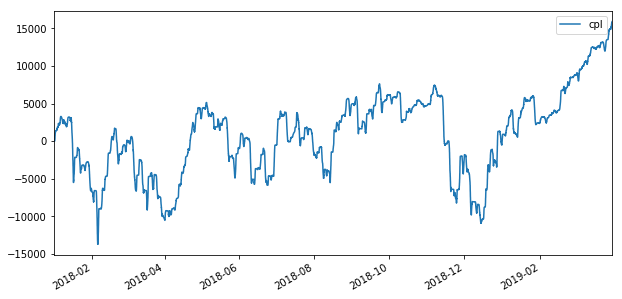

----------------
PnL with ML


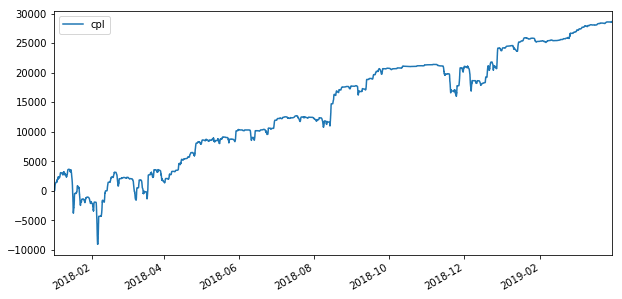

In [10]:
trades['cpl'] = trades.Pnl_Long.cumsum()

test['cpl'] = test.Pnl_Long.cumsum()
print('Original PnL - No ML')

test.plot(x=test.index,y='cpl',figsize=[10,5])
plt.show()
print('----------------')
print('PnL with ML')
trades.plot(x=trades.index,y='cpl',figsize=[10,5])
plt.show()

/Users/niallmurray/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Original PnL - No ML


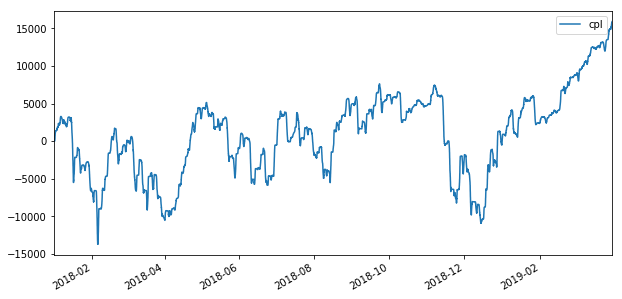

----------------
PnL with ML


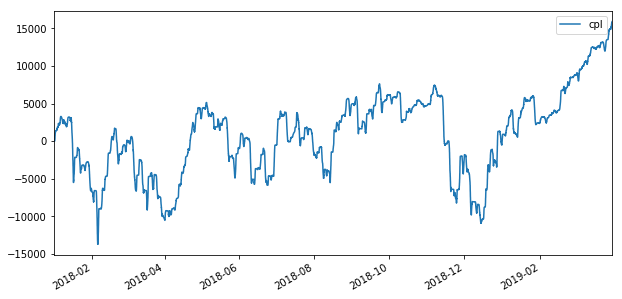

In [104]:
importances = sorted(list(zip(clf.feature_importances_, df.iloc[:,1:-1])),reverse=True)
for i, f in importances:
    print(f, i)